### SimCLR-V2 Training Framework

In [1]:
import timm
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.simclr_v2 import *

## 1. Pretraining

In [2]:
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-4
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [3]:
def get_dls(resize, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    tfms = [[PILImage.create, ToTensor, Resize(resize,method='squish')], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [4]:
bs=128
resize, size = 160, 128

In [5]:
list(L(timm.list_models()).filter(lambda o: "ssl" in o))

['ssl_resnet18',
 'ssl_resnet50',
 'ssl_resnext50_32x4d',
 'ssl_resnext101_32x4d',
 'ssl_resnext101_32x8d',
 'ssl_resnext101_32x16d']

In [6]:
arch_name = "ssl_resnext101_32x4d"

In [7]:
encoder = timm.create_model(arch_name, pretrained=False, num_classes=0)

In [8]:
dls = get_dls(resize, bs)
model = create_simclrv2_model(encoder=encoder, n_in=3, pretrained=False)
learn = Learner(dls, model, SimCLRv2Loss(temp=0.1), 
                cbs=[
                    SimCLRv2(resize, 
                             aug_func=get_batch_augs,
                             blur_s=(1,16)),
                    TerminateOnNaNCallback()])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> GaussBlur2D -- {'p': 0.3, 's': (1, 16), 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)} Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> GaussBlur2D -- {'p': 0.3, 's': (1, 16), 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}


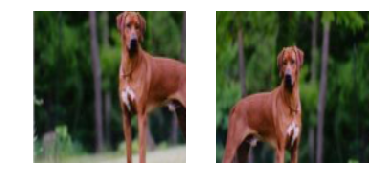

In [9]:
b = dls.one_batch()
learn._split(b)
learn.training = True
learn('before_batch')
learn.sim_cl_rv2.show_one()

In [10]:
learn.to_fp16();

In [11]:
lr=1e-3
epochs=100

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,4.700577,4.748070,03:22
1,4.063446,4.451007,03:20
2,3.627293,3.764135,03:18
3,3.386178,3.429079,03:19
4,3.082767,3.201191,03:19
5,2.730067,3.022031,03:18


In [ ]:
save_name = f'{arch_name}_simclrv2_iwang_sz{size}_epc100'

In [ ]:
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

In [ ]:
learn.recorder.plot_loss()

### 2. Fine-tuning

In [113]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source, folders=['train', 'val'])
    splits = GrandparentSplitter(valid_name='val')(files)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [114]:
dls = get_dls(size,bs=128)

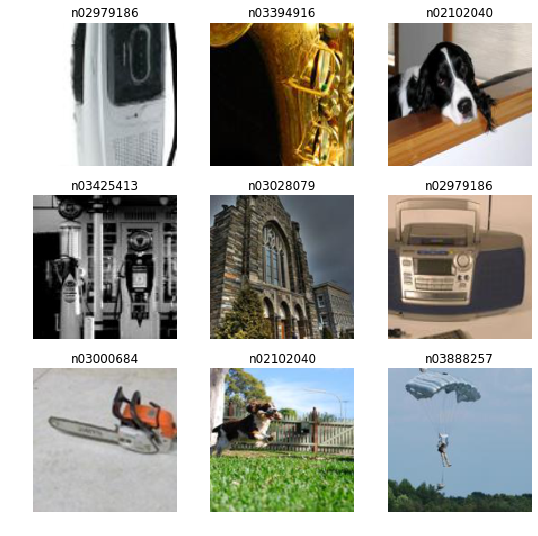

In [115]:
dls.show_batch()

In [116]:
pretrained_encoder = torch.load(learn.path/learn.model_dir/f'{save_name}_encoder.pth')
encoder = timm.create_model(arch_name, pretrained=False, num_classes=0)
encoder.load_state_dict(pretrained_encoder);

In [124]:
classification_head = create_head(2048, first_bn=False, n_out=dls.c, concat_pool=False)
classification_head = nn.Sequential(*classification_head[2:])
model = nn.Sequential(encoder, classification_head)

In [126]:
learn = Learner(dls, model, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy],
                loss_func=LabelSmoothingCrossEntropy())

In [127]:
learn.to_fp16();

In [128]:
epochs = 5
lr=1e-2
learn.unfreeze()
learn.fit_flat_cos(epochs, lr)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.306716,3.625341,0.000509,0.120896,00:24
1,2.131196,3.625491,0.000255,0.161110,00:24
2,2.045177,3.599267,0.000255,0.204632,00:25
3,1.958371,3.716891,0.000000,0.193942,00:25
4,1.879542,3.457767,0.005854,0.284551,00:27


### 3. Knowledge-distillation

## Downstream Task

In [ ]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source, folders=['train', 'val'])
    splits = GrandparentSplitter(valid_name='val')(files)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [ ]:
def do_train(epochs=5, runs=5, size=size, bs=bs, lr=lr, save_name=None):
    dls = get_dls(size, bs)
    for run in range(runs):
        print(f'Run: {run}')
        learn = cnn_learner(dls, xresnet34, opt_func=opt_func, normalize=False,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy(),
                pretrained=False)

        if save_name is not None:
            state_dict = torch.load(learn.path/learn.model_dir/f'{save_name}_encoder.pth')
            learn.model[0].load_state_dict(state_dict)
            print("Model loaded...")
            
        learn.unfreeze()
        learn.fit_flat_cos(epochs, lr, wd=wd)

### 5 epochs

In [ ]:
lr = 1e-2
epochs = 5
runs = 5

In [ ]:
do_train(epochs, runs, lr=lr, save_name=save_name)

Run: 0
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.173769,1.954930,0.473148,0.866887,00:22
1,1.029763,1.831063,0.523797,0.878850,00:22
2,0.969776,1.816909,0.558666,0.869687,00:22
3,0.915550,1.743909,0.584373,0.907101,00:22
4,0.829070,1.546164,0.647238,0.922627,00:22


Run: 1
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.156928,2.031741,0.435989,0.861033,00:22
1,1.027517,1.939481,0.482311,0.884958,00:22
2,0.977137,1.751871,0.547722,0.893866,00:23
3,0.921234,1.708871,0.589972,0.890048,00:22
4,0.843251,1.545160,0.645711,0.924408,00:22


Run: 2
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.175344,1.872386,0.511581,0.882922,00:21
1,1.043144,1.763668,0.555103,0.900993,00:21
2,0.963885,1.912734,0.497073,0.874523,00:21
3,0.941352,1.693227,0.587427,0.913719,00:21
4,0.824273,1.570005,0.635022,0.918045,00:22


Run: 3
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.163305,2.001638,0.462204,0.857470,00:21
1,1.030824,1.922594,0.509544,0.886231,00:21
2,0.971310,1.814036,0.545686,0.877322,00:21
3,0.934993,1.692231,0.586663,0.910919,00:21
4,0.836493,1.601694,0.614915,0.916009,00:21


Run: 4
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.173550,1.968474,0.475439,0.873250,00:21
1,1.032172,1.851037,0.523797,0.876304,00:21
2,0.963610,1.805294,0.536269,0.892339,00:21
3,0.914703,1.849431,0.556885,0.897175,00:21
4,0.826285,1.571437,0.628150,0.923390,00:21


In [ ]:
np.mean([0.647238, 0.645711, 0.635022, 0.614915, 0.628150])

0.6342072

### 20 epochs

In [ ]:
epochs = 20
runs = 3

In [ ]:
do_train(epochs, runs, save_name=save_name)

Run: 0
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.172397,2.023369,0.452787,0.872232,00:21
1,1.048891,1.816604,0.524561,0.906083,00:21
2,0.982772,1.840554,0.552812,0.902265,00:21
3,0.905956,1.855358,0.548231,0.883431,00:21
4,0.879575,1.803466,0.555612,0.898702,00:21
5,0.857640,1.705957,0.597353,0.899466,00:21
6,0.838035,1.681782,0.594299,0.911173,00:22
7,0.824282,1.604416,0.607534,0.923899,00:21
8,0.801727,1.749159,0.600662,0.906592,00:21
9,0.777467,1.545955,0.655638,0.930262,00:21


Run: 1
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.166445,1.948399,0.470858,0.884194,00:21
1,1.032198,2.034898,0.456605,0.864342,00:21
2,0.980184,1.837205,0.547468,0.864851,00:21
3,0.934421,1.787043,0.564266,0.889794,00:21
4,0.896315,1.702195,0.596844,0.912191,00:21
5,0.865639,1.659661,0.602952,0.915500,00:21
6,0.831547,1.766076,0.579028,0.912446,00:21
7,0.808244,1.724547,0.601680,0.900229,00:21
8,0.810060,1.721077,0.604225,0.908883,00:21
9,0.791233,1.636717,0.639348,0.912446,00:21


Run: 2
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.169256,1.922205,0.477984,0.872232,00:21
1,1.037950,1.914560,0.487910,0.882158,00:21
2,0.969144,1.759319,0.567320,0.889285,00:21
3,0.925919,1.835557,0.551031,0.897429,00:21
4,0.874961,1.815813,0.590227,0.903792,00:21
5,0.851673,1.687898,0.593281,0.910919,00:21
6,0.831319,1.663185,0.615424,0.916773,00:21
7,0.821747,1.681809,0.604734,0.909137,00:21
8,0.798910,1.709096,0.607534,0.915755,00:21
9,0.797166,1.622134,0.619242,0.922372,00:21


In [ ]:
np.mean([0.674472, 0.658692, 0.680326])

0.6711633333333333

### 80 epochs

In [ ]:
epochs = 80
runs = 1

In [ ]:
do_train(epochs, runs, save_name=save_name)

Run: 0
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.184580,1.934737,0.472894,0.883431,00:21
1,1.041719,1.815343,0.535505,0.894375,00:21
2,0.969628,1.711633,0.578264,0.905828,00:21
3,0.914409,1.691567,0.588954,0.903792,00:21
4,0.877764,1.736985,0.592517,0.914991,00:21
5,0.867082,1.731112,0.594553,0.898956,00:21
6,0.841451,1.645919,0.622805,0.917791,00:21
7,0.821224,1.626836,0.632985,0.918809,00:21
8,0.804854,1.711660,0.595571,0.900993,00:21
9,0.798585,1.588638,0.639094,0.913719,00:21


### 200 epochs

In [ ]:
epochs = 200
runs = 1

In [ ]:
do_train(epochs, runs, save_name=save_name)

Run: 0
Model loaded...


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.159623,1.955200,0.479002,0.875541,00:21
1,1.044386,1.850894,0.506745,0.887758,00:21
2,0.977252,1.789244,0.539323,0.893612,00:21
3,0.934943,1.879216,0.529142,0.903538,00:21
4,0.884970,1.769760,0.559684,0.896411,00:21
5,0.867082,1.705800,0.603716,0.906592,00:21
6,0.834456,1.719087,0.588190,0.902265,00:21
7,0.816135,1.782088,0.587681,0.884194,00:21
8,0.807418,1.626077,0.635531,0.915755,00:21
9,0.790614,1.705302,0.607025,0.901756,00:21
